In [1]:
# from oxksc.cbvc import cbv
import lightkurve as lk
import tarfile
import glob
import matplotlib.pyplot as plt
# import fitsio 
import numpy as np
from scipy.stats import skew

import utils
from astropy.timeseries import BoxLeastSquares, LombScargle
from scipy.optimize import curve_fit
from utils import amplitude_spectrum
import batman

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [50]:
import glob
import numpy as np
# kplr009845898
file = glob.glob('data/lc_pdc/*5202905.csv*')
time, flux, flux_err = np.loadtxt(file[0]).T
flux -= 1
flux *= 1e3
time = np.ascontiguousarray(time)

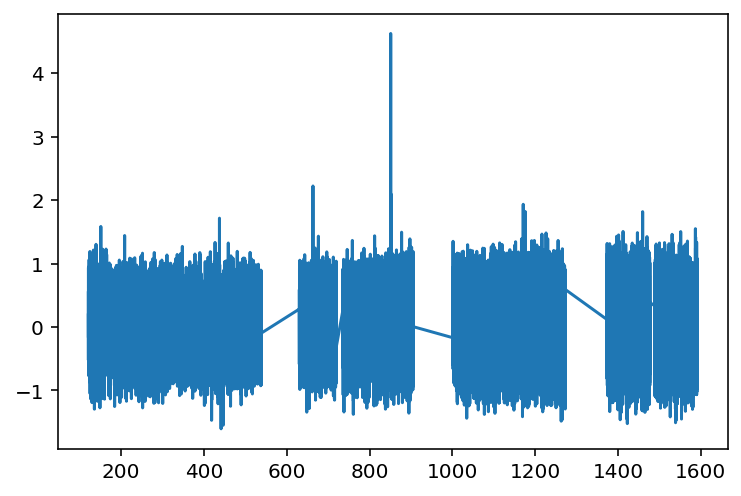

In [51]:
plt.plot(time, flux)

In [61]:
def grad_model(time, freq, amp, phi):
    factor = 2 * np.pi * freq * time + phi
    return np.array([
        -2*np.pi*amp*time*np.sin(factor),
        np.cos(factor),
        -1 * amp * np.sin(factor)
    ]).T

def dft_phase(x, y, f):
    expo = 2.0 * np.pi * f * x
    ft_real = np.sum(y * np.cos(expo))
    ft_imag = np.sum(y * np.sin(expo))
    return np.arctan2(ft_imag, ft_real)

def model(time, freq, amp, phi):
    return amp * np.cos((2 * np.pi * freq * time) + phi)

def prewhiten(time, flux, fmin=1, fmax=None):
    theta = initialize_theta(time, flux, fmin, fmax)
    popt, _ = curve_fit(model, time, flux, p0=theta, jac=grad_model)
    return flux - model(time, *popt), popt, theta

def prewhiten_test(time, flux, fmin=1, fmax=None):
    theta = initialize_theta(time, flux, fmin, fmax)
    return flux - model(time, *theta)

def find_highest_peak(f, a):
    """
    Find the frequency of the highest peak in the periodogram, using a
    3-point parabolic interpolation.
    """
    nu, p = f, a
    nu, p = np.atleast_1d(nu, p)

    # Get index of highest peak.
    imax = np.argmax(p)

    # Determine the frequency value by parabolic interpolation
    if imax == 0 or imax == p.size - 1:
        nu_peak = p[imax]
    else:
        # Get values around the maximum.
        frq1 = nu[imax-1]
        frq2 = nu[imax]
        frq3 = nu[imax+1]
        y1 = p[imax-1]
        y2 = p[imax]
        y3 = p[imax+1]

        # Parabolic interpolation formula.
        t1 = (y2-y3) * (frq2-frq1)**2 - (y2-y1) * (frq2-frq3)**2
        t2 = (y2-y3) * (frq2-frq1) - (y2-y1) * (frq2-frq3)
        nu_peak = frq2 - 0.5 * t1/t2
    return nu_peak

def estimate_background(x, y, log_width=0.05):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

def initialize_theta(time, flux, fmin, fmax):
    f, a = amplitude_spectrum(time, flux, fmin=fmin, fmax=fmax, oversample_factor=5.)
    # Get freq of max power
    f0 = find_highest_peak(f, a)
    # Calculate a0 at f0
    a0 = np.sqrt(LombScargle(time, flux).power(f0, method="fast", normalization="psd")) * np.sqrt(4.0 / len(time))
    # Calculate phi0, since ASTC need to negative it
    phi0 = -1 * dft_phase(time, flux, f0)
    return f0, a0, phi0

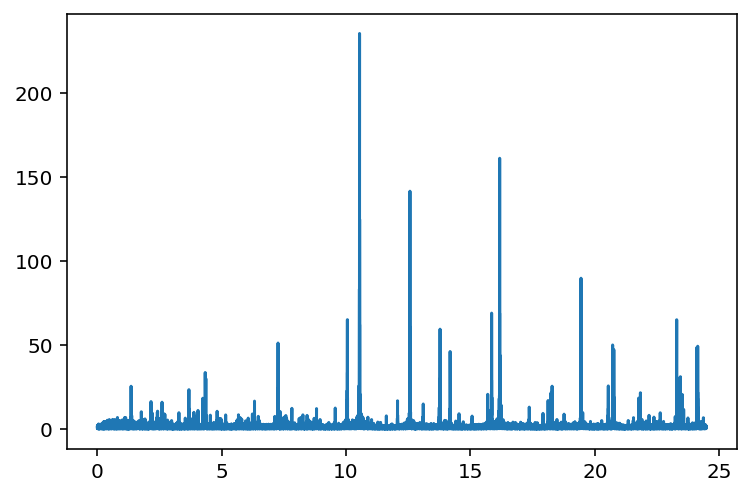

In [53]:
f, a = amplitude_spectrum(time, flux)
bkg = estimate_background(f, a)

plt.plot(f,a / bkg)

In [62]:
import tqdm
removed = []
theta = []
f, a = amplitude_spectrum(time, flux)

for i in tqdm.tqdm(range(100)):
    flux = prewhiten_test(time, flux, fmin=1)

100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


In [57]:
theta = np.array(theta)
removed = np.array(removed)

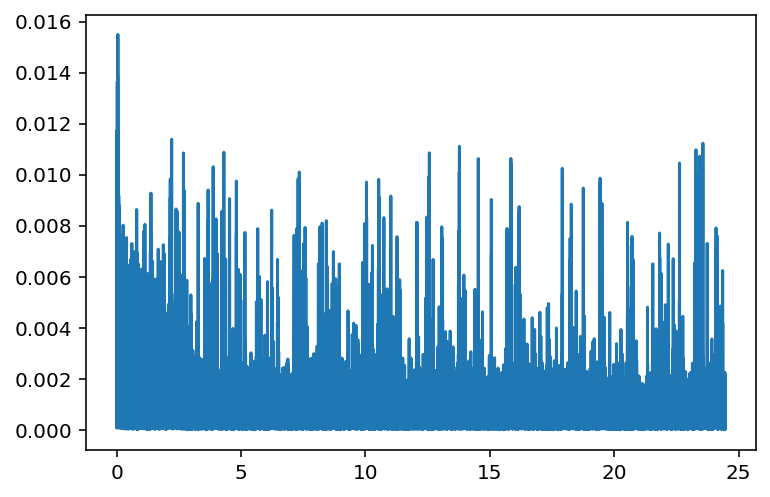

In [60]:
plt.plot(*amplitude_spectrum(time, flux))

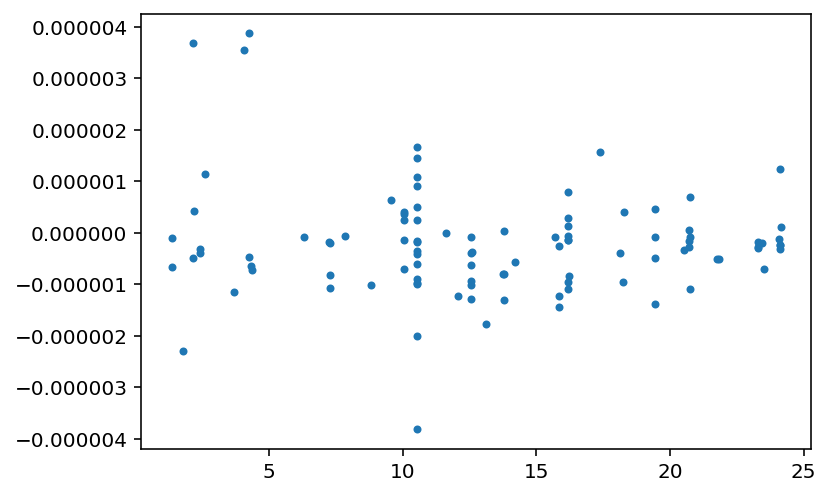

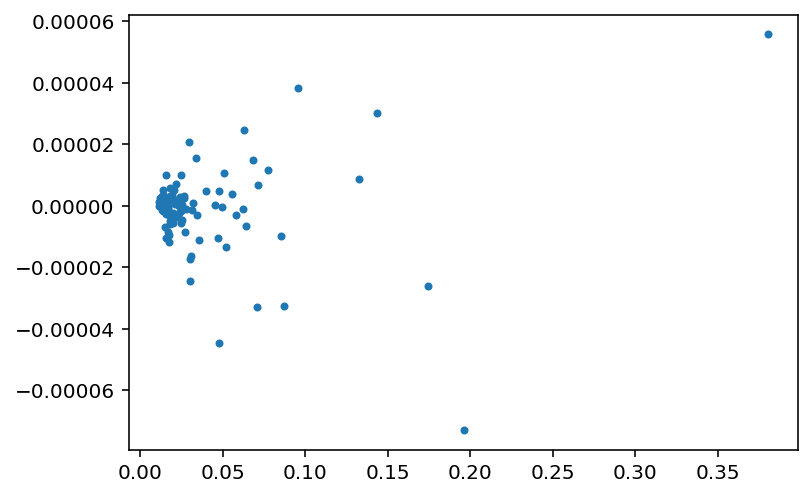

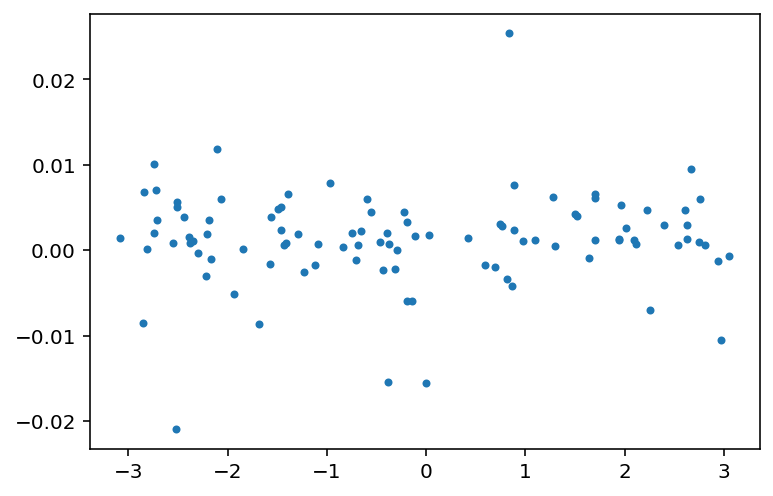

In [58]:
for i in range(3):
    
    plt.plot(theta[:,i], theta[:,i]-removed[:,i], '.')
    plt.show()

In [43]:
grads = grad_model(time, *theta[0])

In [40]:
theta - res.x

array([ 1.27495454e-08, -1.00046760e-08, -9.94042074e-05])

In [16]:
from sympy.printing import latex

In [34]:
from sympy import *

omega, amp, phi, t, y = symbols(r'\omega a \phi t y')

In [36]:
y = amp * cos((omega * t) + phi)
y

a*cos(\omega*t + \phi)

In [40]:
diff(y, phi)

-a*sin(\omega*t + \phi)

In [65]:
%%time
prewhiten(time, flux)

CPU times: user 1.08 s, sys: 87.5 ms, total: 1.17 s
Wall time: 536 ms


(array([ 0.00052063, -0.00107773,  0.00026889, ...,  0.00432861,
         0.00077896,  0.004047  ]),
 array([ 1.94776761e+01,  1.74254796e-03, -3.13679391e-01]))

In [ ]:
 return amp * np.cos((omega * time) + phi)

In [60]:
res

array([ 1.94776761e+01,  1.74254796e-03, -3.13679391e-01])

In [69]:
pi

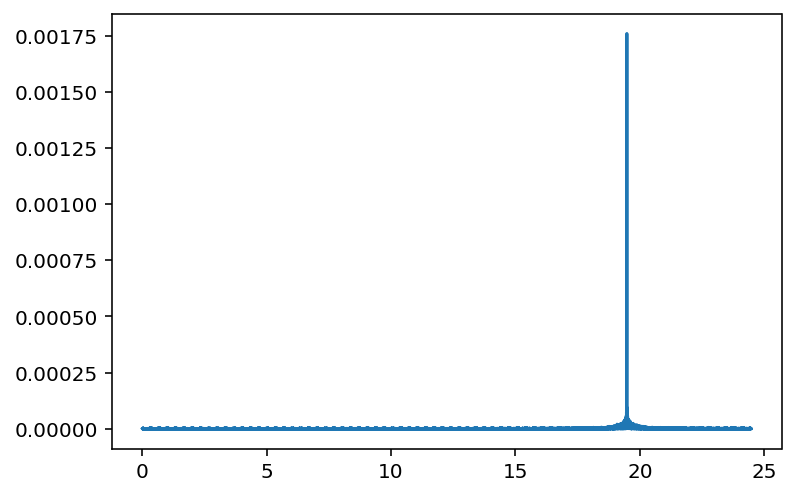

In [ ]:
from scipy.optimize import minimize

def solve_leastsq(t, y, f):
    arg = 2.0 * np.pi * f * t[:, None]
    D = np.concatenate([np.cos(arg), np.sin(arg)], axis=1)
    DTD = D.T.dot(D)
    DTy = D.T.dot(y[:, None])
    W_hat = np.linalg.solve(DTD, DTy)
    model = np.squeeze(D.dot(W_hat))
    return W_hat, model

def dft_phase(x, y, f):
    expo = 2.0 * np.pi * f * x
    ft_real = np.sum(y * np.cos(expo))
    ft_imag = np.sum(y * np.sin(expo))
    return np.arctan2(ft_imag, ft_real)

# def model(time, freq, amp, phi):
#     return amp * np.cos((2 * np.pi * freq * time) + phi)

# def prewhiten(time, flux, freq, amp):
#     phase = -1 * dft_phase(time, flux, freq)
#     popt, _ = curve_fit(model, time, flux, p0=[freq, amp, phase])
#     return flux - model(time, *popt), popt

def find_highest_peak(f, a):
    """
    Find the frequency of the highest peak in the periodogram, using a
    3-point parabolic interpolation.
    """
    nu, p = f, a
    nu, p = np.atleast_1d(nu, p)

    # Get index of highest peak.
    imax = np.argmax(p)

    # Determine the frequency value by parabolic interpolation
    if imax == 0 or imax == p.size - 1:
        nu_peak = p[imax]
    else:
        # Get values around the maximum.
        frq1 = nu[imax-1]
        frq2 = nu[imax]
        frq3 = nu[imax+1]
        y1 = p[imax-1]
        y2 = p[imax]
        y3 = p[imax+1]

        # Parabolic interpolation formula.
        t1 = (y2-y3) * (frq2-frq1)**2 - (y2-y1) * (frq2-frq3)**2
        t2 = (y2-y3) * (frq2-frq1) - (y2-y1) * (frq2-frq3)
        nu_peak = frq2 - 0.5 * t1/t2
    return nu_peak

def model_func(theta, time):
    freq, amp, phi = theta
    return amp * np.cos((2 * np.pi * freq * time) + phi)

def prewhiten(time, flux):
    theta = initialize_theta(time, flux)    
    # Fit
    popt, _ = curve_fit(model, time, flux, p0=theta)
    return flux - model(time, *popt), popt

def initialize_theta(time, flux):
    f, a = amplitude_spectrum(time, flux, oversample_factor=5.)
    # Get freq of max power
    f0 = find_highest_peak(f, a)
    # Calculate a0 at f0
    a0 = np.sqrt(LombScargle(time, flux).power(f0, method="fast", normalization="psd")) * np.sqrt(4.0 / len(time))
    # Calculate phi0
    phi0 = -1 * dft_phase(time, flux, f0)
    return f0, a0, phi0

def grad_func_oss(theta, time, flux):
    freq, amp, phi = theta
    factor = 2 * np.pi * freq * time + phi
    return np.array([
        2*np.pi*amp*time * (-1*amp*np.cos(factor) + flux) * np.sin(factor),
        -1.0 * (-1. * amp * np.cos(factor) + flux) * np.cos(factor),
        amp * (-1. * amp * np.cos(factor) + flux) * np.sin(factor)
    ]).sum(axis=1)

def minfunc(theta, time, flux):
    model = model_func(theta, time)
    return 0.5 * np.sum((flux - model) ** 2)

In [ ]:
%%time
theta = initialize_theta(time ,flux)
res = minimize(minfunc, theta, args=(time, flux), 
         jac=grad_func_oss
        )
res